In [1]:
import pandas as pd
import ta
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
import warnings
from yahooquery import Screener
from binance import Client
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from binance.enums import HistoricalKlinesType
import requests
import datetime
import seaborn as sns
import matplotlib
import scipy as sp
from scipy import stats
import pygad
warnings.filterwarnings('ignore')

In [2]:
#pip install matplotlib

In [3]:
#pip install scikit-learn

In [4]:
#pip install yfinance

In [5]:
#pip install ta

In [6]:
#pip install yahooquery

In [21]:
#-- We create several normalizations
def normalize(df):
    """_summary_
    
    Method of normalization also called zscore

    Args:
        df (dataframe): signal dataframe

    Returns:
        dataframe: normalized df
    """
    temp=df.copy()
    rows=temp.shape[0]
    cols=temp.shape[1]
    #temp=temp.replace([-np.inf,np.inf],[np.nan,np.nan])
    #temp=temp.dropna(thresh=int(0.5*rows), axis=1) #remove columns with less than 50% of values
    #temp=temp.dropna(how='all', axis=0) #remove empty rows
    #temp=temp.dropna(how='all', axis=1) #remove empty columns
    #temp=range_val(temp,-3,3)
    temp=temp.sub(temp.mean(axis=1), axis=0)
    temp=temp.div(temp.std(axis=1),axis=0)
    temp=temp.clip(-3, 3)
    temp=temp.sub(temp.mean(axis=1), axis=0)
    temp=temp.div(temp.std(axis=1),axis=0)
    return temp

def normalize2(df):
    """_summary_

    Normalization by mean and median of absolute values
    
    Args:
        df (dataframe): signal dataframe

    Returns:
        dataframe: normalized df
    """
    temp=df.copy()
    rows=temp.shape[0]
    cols=temp.shape[1]
    #temp=temp.replace([-np.inf,np.inf],[np.nan,np.nan])
    #temp=temp.dropna(how='all', axis=0) #remove empty rows
    #temp=temp.dropna(how='all', axis=1) #remove empty columns
    temp=temp.sub(temp.mean(axis=1), axis=0)
    temp=temp.div(temp.abs().median(axis=1),axis=0)
    return temp

#-- function to scale each row of a dataframe between two values (tmin and tmax)
def range_val(df,tmin,tmax):
    temp=df.copy()
    temp=temp.sub(temp.min(axis=1), axis=0)
    temp=temp.div((temp.max(axis=1)-temp.min(axis=1)),axis=0)
    temp=temp*(tmax-tmin)+tmin
    return temp

#-- function to normalize returns by rolling volatility
def normalize_returns(returns,window):
    returns=returns.div(returns.rolling(window).std())
    return returns

def normalize3(df):
    temp=df.rank(axis=1,method='max')
    temp=temp.divide(temp.max(axis=1),axis=0)

def normalize4(df):
    """_summary_

    Normalization by power transformer with the method yeo-johnson
    
    Args:
        df (dataframe): signal dataframe

    Returns:
        dataframe: normalized df
    """
    scaler = PowerTransformer(method="yeo-johnson")
    temp=pd.DataFrame(scaler.fit_transform(df.T).T,columns=df.columns,index=df.index)
    temp=temp.clip(-3, 3)
    return temp

def normalize5(df):
    """_summary_
    
    Normalization by quantile transformer with a normal distribution as an output

    Args:
        df (dataframe): signal dataframe

    Returns:
        dataframe: normalized df
    """
    scaler = QuantileTransformer(n_quantiles=100,output_distribution="normal")
    temp=pd.DataFrame(scaler.fit_transform(df.T).T,columns=df.columns,index=df.index)
    temp=temp.clip(-3, 3)
    return temp

def normalize6(df):
    """_summary_
        Normalization of a signal by ranks on a row
    Args:
        df (dataframe): signal dataframe

    Returns:
        dataframe: normalized df
    """
    temp = df.rank(axis=1, pct=True)
    temp=temp.sub(temp.mean(axis=1), axis=0)
    temp=temp.div(temp.std(axis=1),axis=0)
    temp = temp.clip(-3, 3, axis=1)
    return temp

#-- function to create a dataframe of forward returns with a sum of "window" values in the future
def forward_returns(returns,window):
    #returns=returns.shift(1)
    return returns.shift(-window).rolling(window).sum() #.shift(1)

In [8]:
# horizons=[1, 2, 3, 5, 10, 20, 30, 60, 120]
# forwards = [returns.rolling(horizon).sum().shift(-horizon) for horizon in horizons]

# Collecting coins symbols

Two different ways

In [3]:
all_frames={}
s = Screener()
data = s.get_screeners('all_cryptocurrencies_us', count=150) #count is the number of coins we want

# data is in the quotes key
dicts = data['all_cryptocurrencies_us']['quotes']
coins = [d['symbol'] for d in dicts]

In [4]:
all_frames={}
def get_futures_symbols():
    base = 'https://fapi.binance.com'
    endpoint = f'{base}/fapi/v1/exchangeInfo'
    
    params = {}
    result = requests.get(endpoint, params=params).json()

    usdt = []
    for symb in result['symbols']:
        if symb['status'] == 'TRADING':
            if symb['symbol'].endswith('USDT'):
                usdt.append(symb['symbol'])
    #bad=["OP-USD","UNI-USD"]
    #symbols=[i[:-4]+"-USD" for i in usdt]
    #symbols=[i for i in symbols if i not in bad]
    return usdt
coins = get_futures_symbols()

#-- we put BTCUSDT in the first place
coins.remove("BTCUSDT")
coins.insert(0,"BTCUSDT")

# Collecting past records

In [11]:
#-- Collection with yahoo finance


# %%time
# historic={}
# #download all data
# #temp=yf.download(tickers=" ".join(coins[:]),period="1y",interval="1h",ignore_tz=False)[["Open","Close","High","Volume","Low"]]
# temp=yf.download(tickers=" ".join(coins[:]),period="5y",interval="1d")[["Open","Close","High","Volume","Low"]]

# #delete rows with Nan and last row because it is incomplete
# #temp=temp[:-1].dropna(axis=0,subset=[["Volume"],["BTC-USD"]])
# #temp=temp.dropna(how='all', axis=0) #drop empty rows

# #rename columns by just keeping name of the coins
# #temp.columns.set_levels([i.split("-")[0] for i in temp.columns.levels[1]],level=1,inplace=True)
# historic["High"]=temp["High"].copy()
# historic["Low"]=temp["Low"].copy()
# historic["Close"]=temp["Close"].copy()
# historic["Open"]=temp["Open"].copy()
# historic["Volume"]=temp["Volume"].copy()
# historic["Open"].info()

In [5]:
#-- Collection with binance api

historic={}
historic["High"]=pd.DataFrame()
historic["Volume"]=pd.DataFrame()
historic["Low"]=pd.DataFrame()
historic["Open"]=pd.DataFrame()
historic["Close"]=pd.DataFrame()
from binance.enums import HistoricalKlinesType
for i in coins:
    #print(i)   
    try: 
        klinesT = Client().get_historical_klines(i, Client.KLINE_INTERVAL_1DAY, "01 january 2017",
                                                 klines_type=HistoricalKlinesType.FUTURES)
        df = pd.DataFrame(klinesT, columns=[
                        'timestamp', 'Open', 'High', 'Low', 'Close',
                        'Volume', 'close_time', 'quote_av', 'trades',
                        'tb_base_av', 'tb_quote_av', 'ignore'])
        df.index = df['timestamp'].apply(
                        lambda x: datetime.datetime.fromtimestamp(x / 1000))
        df=df[["Open","Low","Close","High","Volume"]]
        cols=df.columns
        name=i[:-4]
        df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
        historic["Open"][name]=df["Open"]
        historic["Close"][name]=df["Close"]
        historic["Volume"][name]=df["Volume"]
        historic["High"][name]=df["High"]
        historic["Low"][name]=df["Low"]
    except:
        continue


In [13]:
#-- Collect data about close, open, volume, high and low for multiple coins
#-- We create a dict that contains 5 dataframes (one for each type of records)
# historic={}
# historic["High"]=pd.DataFrame()
# historic["Volume"]=pd.DataFrame()
# historic["Low"]=pd.DataFrame()
# historic["Open"]=pd.DataFrame()
# historic["Close"]=pd.DataFrame()
# high=pd.DataFrame()
# for i in coins:
#     name=i.split("-")[0]
#     temp=yf.Ticker(i)
#     temp=temp.history(period="5y")
#     historic["High"][name]=temp["High"]
#     historic["Low"][name]=temp["Low"]
#     historic["Close"][name]=temp["Close"]
#     historic["Open"][name]=temp["Open"]
#     historic["Volume"][name]=temp["Volume"]
# historic["Volume"].tail()

# Indicators

### Momentum Indicators

In [14]:
def get_rsi(value,df):
    all_df=pd.DataFrame()
    for i in df["Open"].columns:
        name=i.split("-")[0]
        all_df[name]=ta.momentum.rsi(close=df['Close'][name], window=value)
    return all_df

#-- Default : 14
all_frames["RSI"]=get_rsi(14,historic)

In [15]:
def get_stoch_rsi(value,df):
    all_df=pd.DataFrame()
    for i in df["Open"].columns:
        name=i.split("-")[0]
        all_df[name]=ta.momentum.stochrsi(close=df['Close'][name], window=value, smooth1=3, smooth2=3)
    return all_df

#-- Default : 14
all_frames["stoch_rsi_14"]=get_stoch_rsi(14,historic)
all_frames["stoch_rsi_10"]=get_stoch_rsi(10,historic)
all_frames["stoch_rsi_20"]=get_stoch_rsi(20,historic)
all_frames["stoch_rsi_25"]=get_stoch_rsi(25,historic)

In [16]:
def get_stoch_rsi_d(value,df):
    all_df=pd.DataFrame()
    for i in df["Open"].columns:
        name=i.split("-")[0]
        all_df[name]=ta.momentum.stochrsi_d(close=df['Close'][name], window=value, smooth1=3, smooth2=3)
    return all_df

#-- Default : 14
all_frames["stoch_rsi_d"]=get_stoch_rsi_d(14,historic)

In [17]:
def get_stoch_rsi_k(value,df):
    all_df=pd.DataFrame()
    for i in df["Open"].columns:
        name=i.split("-")[0]
        all_df[name]=ta.momentum.stochrsi_k(close=df['Close'][name], window=value, smooth1=3, smooth2=3)
    return all_df

#-- Default : 14
all_frames["stoch_rsi_k"]=get_stoch_rsi_k(14,historic)

In [18]:
def get_tsi(value1,value2,df):
    all_df=pd.DataFrame()
    for i in df["Open"].columns:
        name=i.split("-")[0]
        all_df[name]=ta.momentum.tsi(close=df['Close'][name], window_slow=value1, window_fast=value2)
    return all_df

#-- Default : 25,13
all_frames["TSI"]=get_tsi(25,13,historic)

In [19]:
def get_aws_oscillator(value1,value2,df):
    all_df=pd.DataFrame()
    for i in df["Open"].columns:
        name=i.split("-")[0]
        all_df[name]=ta.momentum.awesome_oscillator(high=df['High'][name], low=df['Low'][name], window1=value1, window2=value2)
    return all_df

#-- Default : 5,34
all_frames["aws_oscillator"]=get_aws_oscillator(5,34,historic)

In [20]:
def get_kama(value,df):
    all_df=pd.DataFrame()
    for i in df["Open"].columns:
        name=i.split("-")[0]
        all_df[name]=ta.momentum.kama(close=df['Close'][name], window=value, pow1=2, pow2=30)
    return all_df

#-- Default : 10
all_frames["KAMA"]=get_kama(10,historic)

In [21]:
def get_stoch(value1,value2,df):
    all_df=pd.DataFrame()
    for i in df["Open"].columns:
        name=i.split("-")[0]
        all_df[name]=ta.momentum.stoch(close=df['Close'][name],low=df["Low"][name],
                                       high=df["High"][name], window=value1,smooth_window=value2)
    return all_df

#-- Default : 14,3
all_frames["stoch_oscillator"]=get_stoch(14,3,historic)

In [22]:
def get_stoch_signal(value1,value2,df):
    all_df=pd.DataFrame()
    for i in df["Open"].columns:
        name=i.split("-")[0]
        all_df[name]=ta.momentum.stoch_signal(close=df['Close'][name],low=df["Low"][name],
                                              high=df["High"][name], window=value1,smooth_window=value2)
    return all_df

#-- Default : 14,3
all_frames["stoch_oscillator_signal"]=get_stoch_signal(14,3,historic)

In [23]:
def get_williams_r(value,df):
    all_df=pd.DataFrame()
    for i in df["Open"].columns:
        name=i.split("-")[0]
        all_df[name]=ta.momentum.williams_r(close=df['Close'][name],low=df["Low"][name],high=df["High"][name],lbp=value)
    return all_df

#-- Default : 14
all_frames["williams_r"]=get_williams_r(14,historic)

In [24]:
def get_ppo(w1,w2,w3,df):
    all_df=pd.DataFrame()
    for i in df["Open"].columns:
        name=i.split("-")[0]
        all_df[name]=ta.momentum.ppo(close=df['Close'][name],window_slow=w1,window_fast=w2,window_sign=w3)
    return all_df

#-- Default : 26,12,9
all_frames["ppo"]=get_ppo(26,12,9,historic)

In [25]:
def get_ppo_hist(w1,w2,w3,df):
    all_df=pd.DataFrame()
    for i in df["Open"].columns:
        name=i.split("-")[0]
        all_df[name]=ta.momentum.ppo_hist(close=df['Close'][name],window_slow=w1,window_fast=w2,window_sign=w3)
    return all_df

#-- Default : 26,12,9
all_frames["ppo_hist"]=get_ppo_hist(26,12,9,historic)

In [26]:
def get_ppo_signal(w1,w2,w3,df):
    all_df=pd.DataFrame()
    for i in df["Open"].columns:
        name=i.split("-")[0]
        all_df[name]=ta.momentum.ppo_signal(close=df['Close'][name],window_slow=w1,window_fast=w2,window_sign=w3)
    return all_df

#-- Default : 26,12,9
all_frames["ppo_signal"]=get_ppo_signal(26,12,9,historic)

In [27]:
def get_pvo(w1,w2,w3,df):
    all_df=pd.DataFrame()
    for i in df["Open"].columns:
        name=i.split("-")[0]
        all_df[name]=ta.momentum.pvo(volume=df['Volume'][name],window_slow=w1,window_fast=w2,window_sign=w3)
    return all_df

#-- Default : 26,12,9
all_frames["pvo"]=get_pvo(26,12,9,historic)

In [28]:
def get_pvo_signal(w1,w2,w3,df):
    all_df=pd.DataFrame()
    for i in df["Open"].columns:
        name=i.split("-")[0]
        all_df[name]=ta.momentum.pvo_signal(volume=df['Volume'][name],window_slow=w1,window_fast=w2,window_sign=w3)
    return all_df

#-- Default : 26,12,9
all_frames["pvo_signal"]=get_pvo_signal(26,12,9,historic)

In [29]:
def get_pvo_hist(w1,w2,w3,df):
    all_df=pd.DataFrame()
    for i in df["Open"].columns:
        name=i.split("-")[0]
        all_df[name]=ta.momentum.pvo_hist(volume=df['Volume'][name],window_slow=w1,window_fast=w2,window_sign=w3)
    return all_df

#-- Default : 26,12,9
all_frames["pvo_hist"]=get_pvo_hist(26,12,9,historic)

In [30]:
def get_roc(value,df):
    all_df=pd.DataFrame()
    for i in df["Open"].columns:
        name=i.split("-")[0]
        all_df[name]=ta.momentum.roc(close=df['Close'][name],window=value)
    return all_df

#-- Default : 12
all_frames["roc"]=get_roc(12,historic)

### Trend Indicators

In [31]:
def get_ema(value,df):
    all_df=pd.DataFrame()
    for i in df["Open"].columns:
        name=i.split("-")[0]
        all_df[name]=ta.trend.ema_indicator(close=df['Close'][name], window=value)
    return all_df

#-- Default : 15
all_frames["EMA"]=get_ema(15,historic)

In [32]:
def get_sma(value,df):
    all_df=pd.DataFrame()
    for i in df["Open"].columns:
        name=i.split("-")[0]
        all_df[name]=ta.trend.sma_indicator(close=df['Close'][name], window=value)
    return all_df

#-- Default : 12
all_frames["SMA"]=get_sma(12,historic)

In [33]:
def get_macd_diff(value1,value2,df):
    all_df=pd.DataFrame()
    for i in df["Open"].columns:
        name=i.split("-")[0]
        MACD = ta.trend.MACD(close=df['Close'][name], window_fast=value1, window_slow=value2, window_sign=9)
        all_df[name]=MACD.macd_diff()
    return all_df

#-- Default : 12,26
all_frames["macd_diff"]=get_macd_diff(12,26,historic)

In [34]:
def get_macd_signal(value1,value2,df):
    all_df=pd.DataFrame()
    for i in df["Open"].columns:
        name=i.split("-")[0]
        MACD = ta.trend.MACD(close=df['Close'][name], window_fast=value1, window_slow=value2, window_sign=9)
        all_df[name]=MACD.macd_signal()
    return all_df

#-- Default : 12,26
all_frames["macd_signal"]=get_macd_signal(12,26,historic)

In [35]:
def get_adx(value,df):
    all_df=pd.DataFrame()
    for i in df["Open"].columns:
        name=i.split("-")[0]
        all_df[name]=ta.trend.adx(close=df['Close'][name],high=df["High"][name],low=df["Low"][name], window=value)
    return all_df

#-- Default : 14
all_frames["adx"]=get_adx(14,historic)

In [36]:
def get_adx_neg(value,df):
    all_df=pd.DataFrame()
    for i in df["Open"].columns:
        name=i.split("-")[0]
        all_df[name]=ta.trend.adx_neg(close=df['Close'][name],high=df["High"][name],low=df["Low"][name], window=value)
    return all_df

#-- Default : 14
all_frames["adx_neg"]=get_adx_neg(14,historic)

In [37]:
def get_adx_pos(value,df):
    all_df=pd.DataFrame()
    for i in df["Open"].columns:
        name=i.split("-")[0]
        all_df[name]=ta.trend.adx_pos(close=df['Close'][name],high=df["High"][name],low=df["Low"][name], window=value)
    return all_df

#-- Default : 14
all_frames["adx_pos"]=get_adx_pos(14,historic)

In [38]:
def get_aroon_up(value,df):
    all_df=pd.DataFrame()
    for i in df["Open"].columns:
        name=i.split("-")[0]
        all_df[name]=ta.trend.aroon_up(close=df['Close'][name], window=value)
    return all_df

#-- Default : 25
all_frames["aroon_up"]=get_aroon_up(25,historic)

In [39]:
def get_aroon_down(value,df):
    all_df=pd.DataFrame()
    for i in df["Open"].columns:
        name=i.split("-")[0]
        all_df[name]=ta.trend.aroon_down(close=df['Close'][name], window=value)
    return all_df

#-- Default : 25
all_frames["aroon_down"]=get_aroon_down(25,historic)

In [40]:
def get_cci(value1,value2,df):
    all_df=pd.DataFrame()
    for i in df["Open"].columns:
        name=i.split("-")[0]
        all_df[name]=ta.trend.cci(close=df['Close'][name],high=df["High"][name],
                                  low=df["Low"][name], window=value1,constant=value2)
    return all_df

#-- Default : 20,0.015
all_frames["cci_20"]=get_cci(20,0.015,historic)
all_frames["cci_21"]=get_cci(21,0.015,historic)
all_frames["cci_19"]=get_cci(19,0.015,historic)

In [41]:
def get_dpo(value,df):
    all_df=pd.DataFrame()
    for i in df["Open"].columns:
        name=i.split("-")[0]
        all_df[name]=ta.trend.dpo(close=df['Close'][name], window=value)
    return all_df

#-- Default : 20
all_frames["dpo"]=get_dpo(20,historic)

In [42]:
def get_trix(value,df):
    all_df=pd.DataFrame()
    for i in df["Open"].columns:
        name=i.split("-")[0]
        all_df[name]=ta.trend.trix(close=df['Close'][name], window=value)
    return all_df

#-- Default : 15
all_frames["trix"]=get_trix(15,historic)

In [43]:
def get_ichimoku_a(value1,value2,df):
    all_df=pd.DataFrame()
    for i in df["Open"].columns:
        name=i.split("-")[0]
        all_df[name]=ta.trend.ichimoku_a(high=df["High"][name],
                                  low=df["Low"][name], window1=value1,window2=value2)
    return all_df

#-- Default : 9,26
all_frames["ichimoku_a"]=get_ichimoku_a(9,26,historic)

In [44]:
def get_ichimoku_b(value1,value2,df):
    all_df=pd.DataFrame()
    for i in df["Open"].columns:
        name=i.split("-")[0]
        all_df[name]=ta.trend.ichimoku_b(high=df["High"][name],
                                  low=df["Low"][name], window2=value1,window3=value2)
    return all_df

#-- Default : 26, 52
all_frames["ichimoku_b"]=get_ichimoku_b(26,52,historic)

In [45]:
def get_ichimoku_base_line(value1,value2,df):
    all_df=pd.DataFrame()
    for i in df["Open"].columns:
        name=i.split("-")[0]
        all_df[name]=ta.trend.ichimoku_base_line(high=df["High"][name],
                                  low=df["Low"][name], window1=value1,window2=value2)
    return all_df

#-- Default : 9,26
all_frames["ichimoku_base_line"]=get_ichimoku_base_line(9,26,historic)

In [46]:
def get_ichimoku_conversion_line(value1,value2,df):
    all_df=pd.DataFrame()
    for i in df["Open"].columns:
        name=i.split("-")[0]
        all_df[name]=ta.trend.ichimoku_conversion_line(high=df["High"][name],
                                  low=df["Low"][name], window1=value1,window2=value2)
    return all_df

#-- Default : 9,26
all_frames["ichimoku_conversion_line"]=get_ichimoku_conversion_line(9,26,historic)

In [47]:
def get_mass_index(value1,value2,df):
    all_df=pd.DataFrame()
    for i in df["Open"].columns:
        name=i.split("-")[0]
        all_df[name]=ta.trend.mass_index(high=df["High"][name],
                                  low=df["Low"][name], window_fast=value1,window_slow=value2)
    return all_df

#-- Default : 9,25
all_frames["mass_index"]=get_mass_index(9,25,historic)

In [48]:
def get_vortex_neg(value,df):
    all_df=pd.DataFrame()
    for i in df["Open"].columns:
        name=i.split("-")[0]
        all_df[name]=ta.trend.vortex_indicator_neg(high=df["High"][name], close=df["Close"][name],
                                  low=df["Low"][name], window=value)
    return all_df

#-- Default : 14
all_frames["vortex_indicator_neg"]=get_vortex_neg(14,historic)

In [49]:
def get_vortex_pos(value,df):
    all_df=pd.DataFrame()
    for i in df["Open"].columns:
        name=i.split("-")[0]
        all_df[name]=ta.trend.vortex_indicator_pos(high=df["High"][name], close=df["Close"][name],
                                  low=df["Low"][name], window=value)
    return all_df

#-- Default : 14
all_frames["vortex_indicator_pos"]=get_vortex_pos(14,historic)

In [50]:
def get_wma(value,df):
    all_df=pd.DataFrame()
    for i in df["Open"].columns:
        name=i.split("-")[0]
        all_df[name]=ta.trend.wma_indicator(close=df["Close"][name], window=value)
    return all_df

#-- Default : 9
all_frames["WMA"]=get_wma(9,historic)

### Volatility Indicators

In [51]:
def get_bol_h_band(value,df):
    all_df=pd.DataFrame()
    for i in df["Open"].columns:
        name=i.split("-")[0]
        BOL_BAND = ta.volatility.BollingerBands(close=df['Close'][name], window=value, window_dev=2)
        all_df[name]=BOL_BAND.bollinger_hband()
    return all_df

#-- Default : 20
all_frames["bol_h_band"]=get_bol_h_band(20,historic)

In [52]:
def get_bol_l_band(value,df):
    all_df=pd.DataFrame()
    for i in df["Open"].columns:
        name=i.split("-")[0]
        BOL_BAND = ta.volatility.BollingerBands(close=df['Close'][name], window=value, window_dev=2)
        all_df[name]=BOL_BAND.bollinger_lband()
    return all_df

#-- Default : 20
all_frames["bol_l_band"]=get_bol_l_band(20,historic)

In [53]:
def get_bol_mavg(value,df):
    all_df=pd.DataFrame()
    for i in df["Open"].columns:
        name=i.split("-")[0]
        BOL_BAND = ta.volatility.BollingerBands(close=df['Close'][name], window=value, window_dev=2)
        all_df[name]=BOL_BAND.bollinger_mavg()
    return all_df

#-- Default : 20
all_frames["bol_mavg"]=get_bol_mavg(20,historic)

In [54]:
def get_bol_wband(value,df):
    all_df=pd.DataFrame()
    for i in df["Open"].columns:
        name=i.split("-")[0]
        BOL_BAND = ta.volatility.BollingerBands(close=df['Close'][name], window=value, window_dev=2)
        all_df[name]=BOL_BAND.bollinger_wband()
    return all_df

#-- Default : 20
all_frames["bol_wband"]=get_bol_wband(20,historic)

In [55]:
def get_atr(value,df):
    all_df=pd.DataFrame()
    for i in df["Open"].columns:
        name=i.split("-")[0]
        all_df[name]=ta.volatility.average_true_range(high=df['High'][name], low=df['Low'][name],
                                                      close=df['Close'][name], window=value)
    return all_df

#-- Default : 14
all_frames["ATR"]=get_atr(14,historic)

### Volume indicators

In [56]:
def get_acc_dist(df):
    all_df=pd.DataFrame()
    for i in df["Open"].columns:
        name=i.split("-")[0]
        all_df[name]=ta.volume.acc_dist_index(close=df['Close'][name],high=df["High"][name],
                                              low=df["Low"][name],volume=df["Volume"][name])
    return all_df

all_frames["acc_dist"]=get_acc_dist(historic)

In [57]:
def get_chaikin_money_flow(value,df):
    all_df=pd.DataFrame()
    for i in df["Open"].columns:
        name=i.split("-")[0]
        all_df[name]=ta.volume.chaikin_money_flow(close=df['Close'][name],high=df["High"][name],
                                                  low=df["Low"][name],volume=df["Volume"][name],window=value)
    return all_df

#-- Default : 20
all_frames["chaikin_money_flow"]=get_chaikin_money_flow(20,historic)

In [58]:
def get_ease_of_movement(value,df):
    all_df=pd.DataFrame()
    for i in df["Open"].columns:
        name=i.split("-")[0]
        all_df[name]=ta.volume.ease_of_movement(high=df["High"][name],low=df["Low"][name],
                                                volume=df["Volume"][name],window=value)
    return all_df

#-- Default : 14
all_frames["ease_of_movement"]=get_ease_of_movement(14,historic)

In [59]:
def get_force_index(value,df):
    all_df=pd.DataFrame()
    for i in df["Open"].columns:
        name=i.split("-")[0]
        all_df[name]=ta.volume.force_index(close=df['Close'][name],volume=df["Volume"][name],window=value)
    return all_df

#-- Default : 13
all_frames["force_index"]=get_force_index(13,historic)

In [60]:
def get_money_flow_index(value,df):
    all_df=pd.DataFrame()
    for i in df["Open"].columns:
        name=i.split("-")[0]
        all_df[name]=ta.volume.money_flow_index(close=df['Close'][name],volume=df["Volume"][name],
                                                high=df["High"][name],low=df["Low"][name],window=value)
    return all_df

#-- Default : 14
all_frames["money_flow_index"]=get_money_flow_index(14,historic)

In [61]:
def get_on_balance_volume(df):
    all_df=pd.DataFrame()
    for i in df["Open"].columns:
        name=i.split("-")[0]
        all_df[name]=ta.volume.on_balance_volume(close=df['Close'][name],volume=df["Volume"][name])
    return all_df

all_frames["on_balance_volume"]=get_on_balance_volume(historic)

In [62]:
def get_volume_price_trend(df):
    all_df=pd.DataFrame()
    for i in df["Open"].columns:
        name=i.split("-")[0]
        all_df[name]=ta.volume.volume_price_trend(close=df['Close'][name],volume=df["Volume"][name])
    return all_df

all_frames["volume_price_trend"]=get_volume_price_trend(historic)

### Others Indicators

In [63]:
def get_daily_log(df):
    all_df=pd.DataFrame()
    for i in df["Open"].columns:
        name=i.split("-")[0]
        all_df[name]=ta.others.daily_log_return(close=df['Close'][name])
    return all_df

all_frames["daily_log_return"]=get_daily_log(historic)

In [64]:
def get_daily_return(df):
    all_df=pd.DataFrame()
    for i in df["Open"].columns:
        name=i.split("-")[0]
        all_df[name]=ta.others.daily_return(close=df['Close'][name])
    return all_df

all_frames["daily_return"]=get_daily_return(historic)

In [65]:
def get_cumulative_return(df):
    all_df=pd.DataFrame()
    for i in df["Open"].columns:
        name=i.split("-")[0]
        all_df[name]=ta.others.cumulative_return(close=df['Close'][name])
    return all_df

all_frames["cumulative_return"]=get_cumulative_return(historic)

# Signals evaluation

## Tests with different normalizations

In [67]:
#-- we create functions to evaluate our signals
def signals_evaluation(historic,all_signals):
    #-- we create "returns" data frame
    returns=historic["Close"].pct_change()

    #returns=returns.replace([-np.inf,np.inf],[np.nan,np.nan])
    data=[]
    
    #-- we evaluate all signals in the dictionary "all_signals"
    for i in all_signals.keys():
        #--we collect our signal and we normalize it
        temp=normalize(all_frames[i]).copy()
        
        #-- we create pnl with different lags
        #-- we multiply signal with returns, and we check that "returns" have the exact same shape as "signal"
        pnl = (temp.shift(1) * returns[returns.index.isin(temp.index)][temp.columns]).sum(axis=1)
        pnl2 = (temp.shift(2) * returns[returns.index.isin(temp.index)][temp.columns]).sum(axis=1)
        pnl3 = (temp.shift(3) * returns[returns.index.isin(temp.index)][temp.columns]).sum(axis=1)
        pnl5 = (temp.shift(5) * returns[returns.index.isin(temp.index)][temp.columns]).sum(axis=1)
        pnl7 = (temp.shift(7) * returns[returns.index.isin(temp.index)][temp.columns]).sum(axis=1)
        pnl10 = (temp.shift(10) * returns[returns.index.isin(temp.index)][temp.columns]).sum(axis=1)
        
        #-- for each pnl we compute sharpe ratio, pnl sum and volatility
        sharpe=pnl.mean() * (365)**0.5 / pnl.std()
        sharpe2=pnl2.mean() * (365)**0.5 / pnl2.std()
        sharpe3=pnl3.mean() * (365)**0.5 / pnl3.std()
        sharpe5=pnl5.mean() * (365)**0.5 / pnl5.std()
        sharpe7=pnl7.mean() * (365)**0.5 / pnl7.std()
        sharpe10=pnl10.mean() * (365)**0.5 / pnl10.std()
        d={}
        d["Signal_Name"]=i
        d["Sharpe_lag1"]=round(sharpe,3)
        d["Sharpe_lag2"]=round(sharpe2,3)
        d["Sharpe_lag3"]=round(sharpe3,3)
        d["Sharpe_lag5"]=round(sharpe5,3)
        d["Sharpe_lag7"]=round(sharpe7,3)
        d["Sharpe_lag10"]=round(sharpe10,3)
        #d["PNL_lag1"]=round(pnl.sum(),3)
        #d["Volatility_lag1"]=round(pnl.std(),3)
        #d["PNL_lag2"]=round(pnl2.sum(),3)
        #d["Volatility_lag2"]=round(pnl2.std(),3)
        
        #-- for each signal, we precise how rows and columns we have in this signal
        #d["Nrows"]=temp.shape[0]
        #d["Ncols"]=temp.shape[1]
        
        #-- precise number of missing values in signal
        d["pct_empty_values"]=round(temp.isna().sum().sum()/(temp.shape[0]*temp.shape[1])*100,3)
        
        data.append(d)
        
    #-- we return a data frame with all results    
    df=pd.DataFrame.from_dict(data).sort_values("Sharpe_lag1",ascending=False)
    df=df[df["Sharpe_lag1"].isnull()==False].reset_index(drop=True)
    return df

def signals_evaluation_2(historic,all_signals):
    #-- we create "returns" data frame
    returns=historic["Close"].pct_change()

    #returns=returns.replace([-np.inf,np.inf],[np.nan,np.nan])
    data=[]
    
    #-- we evaluate all signals in the dictionary "all_signals"
    for i in all_signals.keys():
        #--we collect our signal and we normalize it
        temp=normalize2(all_frames[i]).copy()
        
        #-- we create pnl with different lags
        #-- we multiply signal with returns, and we check that "returns" have the exact same shape as "signal"
        pnl = (temp.shift(1) * returns[returns.index.isin(temp.index)][temp.columns]).sum(axis=1)
        pnl2 = (temp.shift(2) * returns[returns.index.isin(temp.index)][temp.columns]).sum(axis=1)
        pnl3 = (temp.shift(3) * returns[returns.index.isin(temp.index)][temp.columns]).sum(axis=1)
        pnl5 = (temp.shift(5) * returns[returns.index.isin(temp.index)][temp.columns]).sum(axis=1)
        pnl7 = (temp.shift(7) * returns[returns.index.isin(temp.index)][temp.columns]).sum(axis=1)
        pnl10 = (temp.shift(10) * returns[returns.index.isin(temp.index)][temp.columns]).sum(axis=1)
        
        #-- for each pnl we compute sharpe ratio, pnl sum and volatility
        sharpe=pnl.mean() * (365)**0.5 / pnl.std()
        sharpe2=pnl2.mean() * (365)**0.5 / pnl2.std()
        sharpe3=pnl3.mean() * (365)**0.5 / pnl3.std()
        sharpe5=pnl5.mean() * (365)**0.5 / pnl5.std()
        sharpe7=pnl7.mean() * (365)**0.5 / pnl7.std()
        sharpe10=pnl10.mean() * (365)**0.5 / pnl10.std()
        d={}
        d["Signal_Name"]=i
        d["Sharpe_lag1"]=round(sharpe,3)
        d["Sharpe_lag2"]=round(sharpe2,3)
        d["Sharpe_lag3"]=round(sharpe3,3)
        d["Sharpe_lag5"]=round(sharpe5,3)
        d["Sharpe_lag7"]=round(sharpe7,3)
        d["Sharpe_lag10"]=round(sharpe10,3)
        #d["PNL_lag1"]=round(pnl.sum(),3)
        #d["Volatility_lag1"]=round(pnl.std(),3)
        #d["PNL_lag2"]=round(pnl2.sum(),3)
        #d["Volatility_lag2"]=round(pnl2.std(),3)
        
        #-- for each signal, we precise how rows and columns we have in this signal
        #d["Nrows"]=temp.shape[0]
        #d["Ncols"]=temp.shape[1]
        
        #-- precise number of missing values in signal
        d["pct_empty_values"]=round(temp.isna().sum().sum()/(temp.shape[0]*temp.shape[1])*100,3)
        
        data.append(d)
        
    #-- we return a data frame with all results    
    df=pd.DataFrame.from_dict(data).sort_values("Sharpe_lag1",ascending=False)
    df=df[df["Sharpe_lag1"].isnull()==False].reset_index(drop=True)
    return df
       

In [68]:
#-- evaluation with signal normalized by mean and standard deviation
signals_evaluation(historic,all_frames).head(10)

,Signal_Name,Sharpe_lag1,Sharpe_lag2,Sharpe_lag3,Sharpe_lag5,Sharpe_lag7,Sharpe_lag10,pct_empty_values
0,stoch_rsi_20,1.639,1.325,1.861,0.896,0.079,0.051,42.945
1,stoch_rsi_k,1.623,1.708,1.480,0.622,0.121,0.012,43.095
2,stoch_rsi_d,1.610,1.451,1.122,0.363,0.016,-0.090,43.259
3,stoch_rsi_25,1.497,1.304,1.715,0.860,0.389,0.227,42.945
4,stoch_rsi_14,1.408,1.349,1.904,0.900,0.187,0.159,42.961
5,stoch_rsi_10,1.370,1.030,1.961,1.079,-0.029,0.166,42.961
6,stoch_oscillator_signal,1.343,1.553,1.366,0.756,0.337,-0.170,44.023
7,cci_19,1.317,1.807,1.998,1.090,0.055,-0.163,44.268
8,cci_20,1.310,1.818,1.961,1.042,0.031,-0.094,44.350
9,vortex_indicator_pos,1.301,1.092,0.968,0.642,0.033,-0.016,43.941


In [69]:
#-- evaluation with signal normalized by mean and median of absolute values
signals_evaluation_2(historic,all_frames).head(10) 

,Signal_Name,Sharpe_lag1,Sharpe_lag2,Sharpe_lag3,Sharpe_lag5,Sharpe_lag7,Sharpe_lag10,pct_empty_values
0,stoch_rsi_k,1.265,1.220,0.991,0.606,0.251,0.056,43.095
1,vortex_indicator_pos,1.222,1.066,0.881,0.598,-0.085,-0.082,43.941
2,stoch_rsi_d,1.169,0.989,0.866,0.423,0.041,-0.067,43.259
3,stoch_oscillator_signal,1.054,1.173,1.059,0.541,0.121,-0.235,44.023
4,bol_wband,0.999,1.167,1.053,0.654,0.513,0.305,44.350
5,force_index,0.845,1.420,1.138,0.695,0.367,0.243,43.860
6,on_balance_volume,0.832,0.794,0.708,0.625,0.392,0.351,42.798
7,stoch_rsi_25,0.822,0.815,1.427,0.725,0.302,-0.033,42.945
8,mass_index,0.755,0.860,0.765,0.558,0.591,0.519,46.066
9,stoch_rsi_20,0.739,0.632,1.620,0.869,0.038,-0.269,42.945


## Tests with returns normalized by rolling volatility and normalized signals

In [161]:
def signals_evaluation_controlled(historic,all_signals,norm_signal,window_vol_returns=180,norm_returns=False):
    #-- we create "returns" data frame
    returns=historic["Close"].pct_change()
    if(norm_returns==True):
        returns=normalize_returns(returns,window_vol_returns)

    #returns=returns.replace([-np.inf,np.inf],[np.nan,np.nan])
    data=[]
    
    #-- we evaluate all signals in the dictionary "all_signals"
    for i in all_signals.keys():
        #--we collect our signal and we normalize it
        temp=all_frames[i].copy()
        if(norm_signal==1):
            temp=normalize(all_frames[i]).copy()
        if(norm_signal==2):
            temp=normalize2(all_frames[i]).copy()
        if(norm_signal==4):
            temp=normalize4(all_frames[i]).copy()
        if(norm_signal==5):
            temp=normalize5(all_frames[i]).copy()
        
        d={}
        d["Signal_Name"]=i
        lags=[1,2,3,5,7,10,21]
        for j in lags:
            #-- we create pnl with different lags
            #-- we multiply signal with returns, and we check that "returns" have the exact same shape as "signal"
            pnl = (temp.shift(j) * returns[returns.index.isin(temp.index)][temp.columns]).sum(axis=1)
            sharpe=pnl.mean() * (365)**0.5 / pnl.std()
            
            #-- for each pnl we compute sharpe ratio, pnl sum and volatility
            d["Sharpe_lag"+str(j)]=round(sharpe,3)
            #d["Volatility_lag"+str(j)]=round(pnl.std(),3)
        
        #-- for each signal, we precise how rows and columns we have in this signal
        #d["Nrows"]=temp.shape[0]
        #d["Ncols"]=temp.shape[1]
        
        #-- precise number of missing values in signal
        d["pct_empty_values"]=round(temp.isna().sum().sum()/(temp.shape[0]*temp.shape[1])*100,3)
        
        data.append(d)
        
    #-- we return a data frame with all results    
    df=pd.DataFrame.from_dict(data).sort_values("Sharpe_lag1",ascending=False)
    df=df[df["Sharpe_lag1"].isnull()==False].reset_index(drop=True)
    return df

#-- historic =  dataframes of Open, Close, High, Low, Volume for futures
#-- all_signals = dictionary of dataframes where each dataframe is a signal
#-- norm_returns = True if you want to normalize your returns by rolling volatility, else False
#-- window_vol_returns = size of rolling window for returns normalization
#-- norm_signal = 1 for normalization by mean an standard deviation, 
#                 2 for normalization by mean and median of absolute values
#                 4 for normalization by PowerTransformer(method="yeo-johnson")
#                 5 for normalization by QuantileTransformer(output_distribution="normal")
eval_controlled_df=signals_evaluation_controlled(
    historic=historic,
    all_signals=all_frames,
    norm_returns=False,
    window_vol_returns=180,
    norm_signal=1
    )
eval_controlled_df #.head(20)

,Signal_Name,Sharpe_lag1,Sharpe_lag2,Sharpe_lag3,Sharpe_lag5,Sharpe_lag7,Sharpe_lag10,Sharpe_lag21,pct_empty_values
0,stoch_rsi_20,1.639,1.325,1.861,0.896,0.079,0.051,0.493,42.945
1,stoch_rsi_k,1.623,1.708,1.480,0.622,0.121,0.012,0.502,43.095
2,stoch_rsi_d,1.610,1.451,1.122,0.363,0.016,-0.090,0.696,43.259
3,stoch_rsi_25,1.497,1.304,1.715,0.860,0.389,0.227,0.262,42.945
4,stoch_rsi_14,1.408,1.349,1.904,0.900,0.187,0.159,0.229,42.961
5,stoch_rsi_10,1.370,1.030,1.961,1.079,-0.029,0.166,0.174,42.961
6,stoch_oscillator_signal,1.343,1.553,1.366,0.756,0.337,-0.170,0.158,44.023
7,cci_19,1.317,1.807,1.998,1.090,0.055,-0.163,0.088,44.268
8,cci_20,1.310,1.818,1.961,1.042,0.031,-0.094,0.064,44.350
9,vortex_indicator_pos,1.301,1.092,0.968,0.642,0.033,-0.016,0.044,43.941


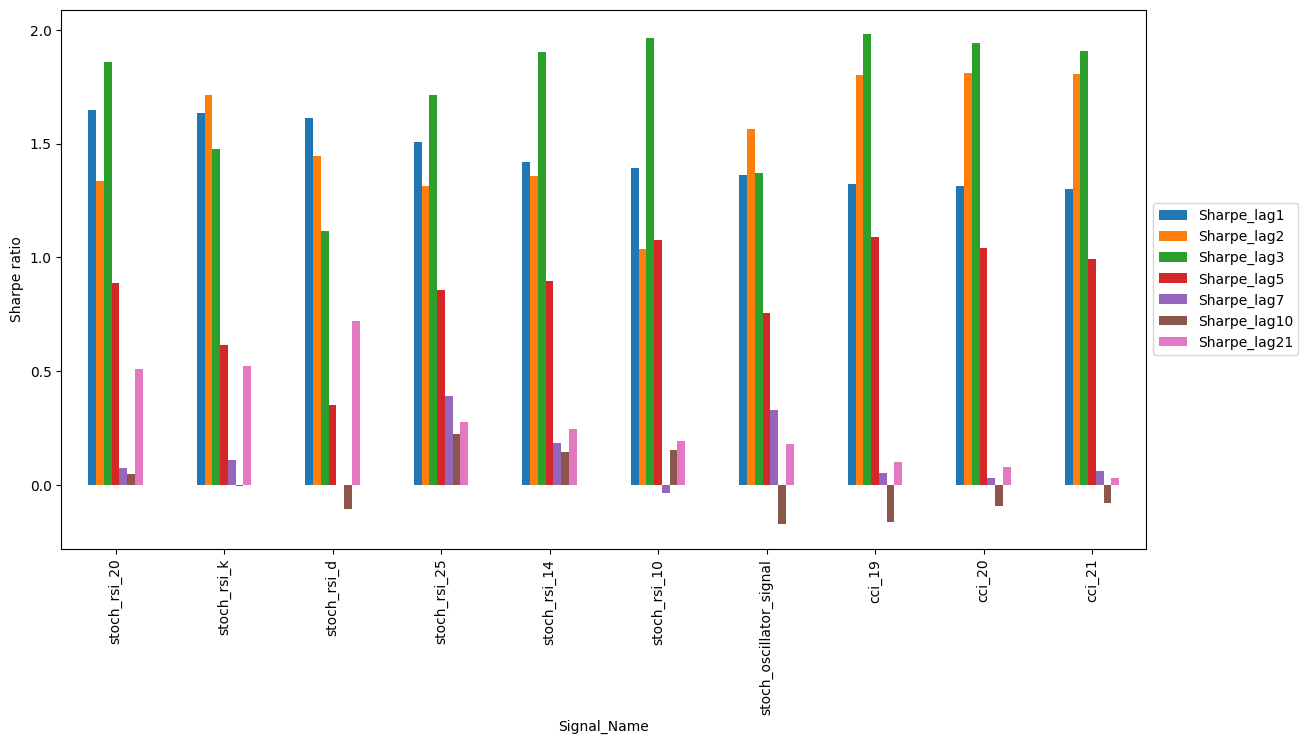

In [61]:
fig, ax = plt.subplots()
eval_controlled_df.iloc[:10].plot.bar(x = 'Signal_Name', y = ["Sharpe_lag1","Sharpe_lag2","Sharpe_lag3","Sharpe_lag5",
                                                              "Sharpe_lag7","Sharpe_lag10","Sharpe_lag21"], rot = 90, ax = ax)
fig.set_size_inches(14, 7)
ax.set_ylabel("Sharpe ratio")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

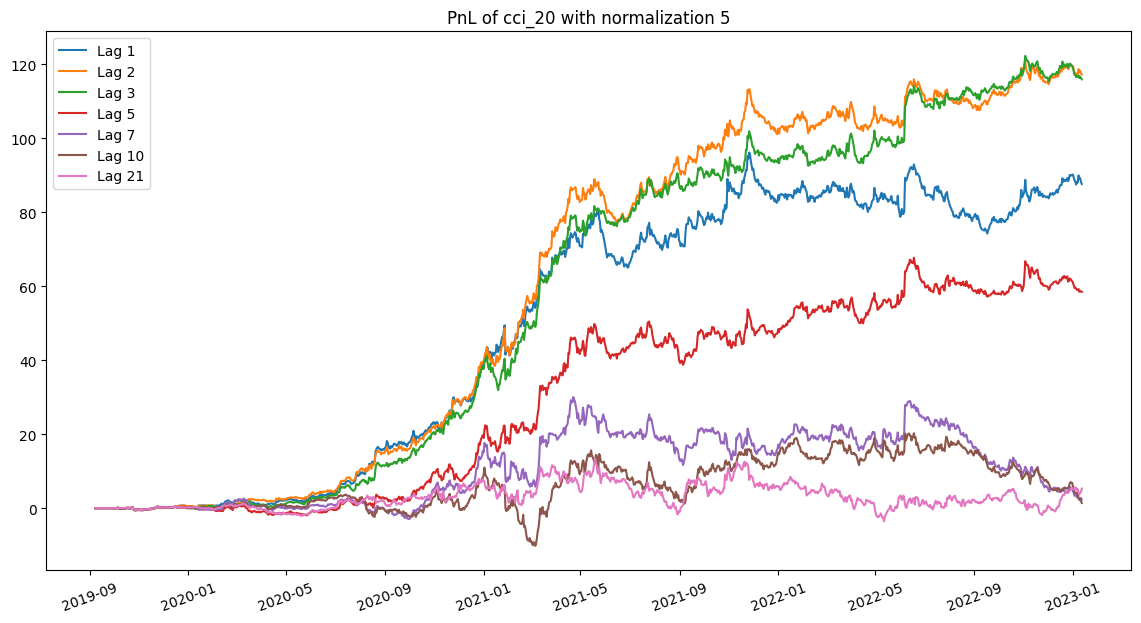

In [62]:
#-- we plot pnl with different lags
def plot_pnl(signal_name,returns,norm_signal,norm_returns=False,window_norm_returns=180):
    if(norm_returns==True):
        returns=normalize_returns(returns,window_norm_returns)
    signal=all_frames[signal_name].copy()
    if(norm_signal==1):
        signal=normalize(all_frames[signal_name]).copy()
    if(norm_signal==2):
        signal=normalize2(all_frames[signal_name]).copy()
    if(norm_signal==4):
        signal=normalize4(all_frames[signal_name]).copy()
    if(norm_signal==5):
        signal=normalize5(all_frames[signal_name]).copy()
        
    lags=[1,2,3,5,7,10,21]
    for i in lags:
        pnl = (signal.shift(i) * returns[returns.index.isin(signal.index)][signal.columns]).sum(axis=1)
        plt.plot(signal.index,pnl.cumsum(), label="Lag "+str(i))
    plt.legend(loc="upper left")
    plt.title("PnL of "+signal_name+ " with normalization "+str(norm_signal))
    plt.xticks(rotation = 20)
    fig=plt.gcf()
    fig.set_size_inches(14, 7)

#-- returns =  matrix of pct_chnage() of close prices
#-- signal_name = name of signal you want to plot
#-- norm_returns = True if you want to normalize your returns by rolling volatility, else False
#-- window_vol_returns = size of rolling window for returns normalization
#-- norm_signal = 1 for normalization by mean an standard deviation, 
#                 2 for normalization by mean and median of absolute values
#                 4 for normalization by PowerTransformer(method="yeo-johnson")
#                 5 for normalization by QuantileTransformer(output_distribution="normal")
returns=historic["Close"].pct_change()
plot_pnl(
    signal_name="cci_20",
    returns=returns,
    norm_returns=False,
    window_norm_returns=90,
    norm_signal=5
    )

## Signal auto-correlation through time (also called half-life)

In [63]:
def signals_propagation(all_frames):
    """_summary_

    Args:
        all_frames (dict): dict of signal dataframes

    Returns:
        dataframe: df of correlation between signals and signals.shift(n)
    """
    data=[]
    for i in all_frames.keys():
        d={}
        d["signal_name"]=i
        y=all_frames[i].copy()
        for j in range(1,20):
            d[str(j)]=y.corrwith(y.shift(j), axis=1).mean()
        data.append(d)    
    df=pd.DataFrame.from_dict(data)
    df=df.set_index("signal_name")
    df=df[df[df.columns[0]].isnull()==False]
    return df
propagation=signals_propagation(all_frames)
propagation.head()


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
signal_name,,,,,,,,,,,,,,,,,,,
RSI,0.976827,0.960274,0.945615,0.932415,0.919875,0.908342,0.897132,0.886503,0.877069,0.868070,0.859548,0.851928,0.844445,0.836983,0.830383,0.824163,0.818220,0.812722,0.807506
stoch_rsi_14,0.771602,0.608967,0.470578,0.354003,0.257255,0.177217,0.107851,0.048488,0.000954,-0.046040,-0.089680,-0.123657,-0.149491,-0.138327,-0.129316,-0.121905,-0.110191,-0.096989,-0.085983
stoch_rsi_10,0.687602,0.478167,0.320684,0.194446,0.092162,0.012276,-0.055975,-0.117768,-0.159715,-0.140201,-0.125467,-0.103984,-0.088029,-0.078568,-0.073271,-0.073667,-0.063558,-0.050359,-0.043089
stoch_rsi_20,0.827242,0.704136,0.601656,0.511870,0.431622,0.362408,0.298391,0.239436,0.188590,0.140041,0.096071,0.059403,0.021194,-0.015907,-0.050226,-0.080179,-0.099497,-0.116848,-0.133060
stoch_rsi_25,0.864614,0.765374,0.678803,0.599693,0.530028,0.469774,0.411145,0.357995,0.312622,0.268655,0.228590,0.191091,0.154654,0.118136,0.085843,0.055462,0.029677,0.007175,-0.015109


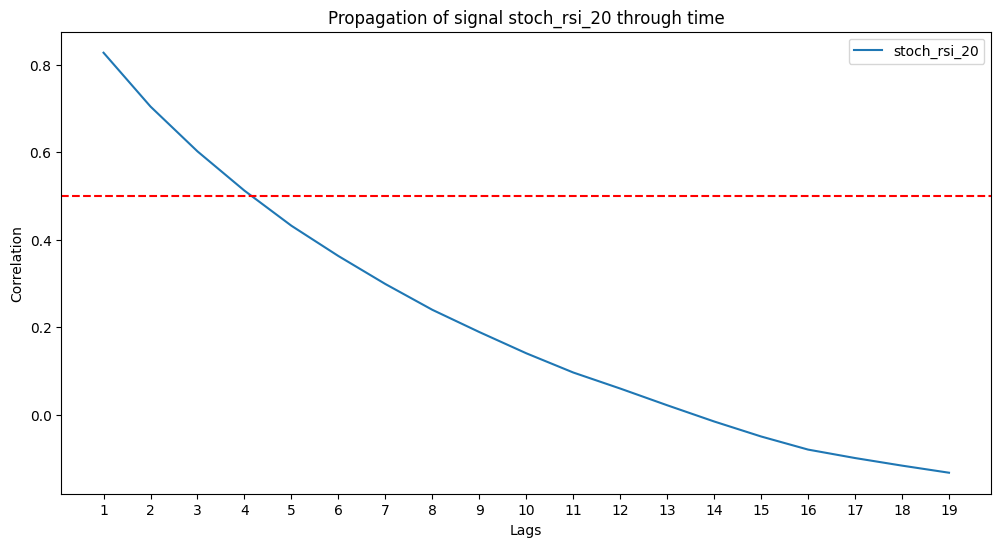

In [64]:
def plot_signal_propagation(name,propagation):
    """_summary_
    
    Function to plot correlation between signal and signal.shift(n)
    
    Args:
        name (string): name of a signal
        propagation (dataframe): dataframe of correlations between signal and signal.shift(n)
    """
    plt.plot(propagation.columns,propagation[propagation.index==name].values[0], label=name)
    plt.legend(loc="upper right")
    plt.xlabel("Lags")
    plt.ylabel("Correlation")
    plt.title("Propagation of signal "+name+" through time")
    plt.axhline(y = 0.5, color = 'r', linestyle = 'dashed')
    fig=plt.gcf()
    fig.set_size_inches(12,6)
plot_signal_propagation("stoch_rsi_20",propagation)

## Forward returns

In [65]:
def auto_correlation_forward(returns,all_signals):
    data=[]
    for i in all_signals.keys():
        d={}
        d["signal_name"]=i
        s=all_signals[i].copy()
        signal=normalize(s)
        for j in range(1,31,2):
            #-- we compute forward returns between t+1 and t+1+i
            forward=forward_returns(returns,j)
            d[str(j)]=signal.corrwith(forward, axis=1).mean()
        data.append(d)    
    df=pd.DataFrame.from_dict(data)
    df=df.set_index("signal_name")
    df=df[df[df.columns[0]].isnull()==False]
    return df
returns=historic["Close"].pct_change()
test= {k: all_frames[k] for k in list(all_frames.keys())[:20]}
auto_corr_forward=auto_correlation_forward(returns=returns,all_signals=all_frames)
auto_corr_forward.head()

,1,3,5,7,9,11,13,15,17,19,21,23,25,27,29
signal_name,,,,,,,,,,,,,,,
RSI,-0.000643,0.015788,0.019762,0.017862,0.015692,0.017072,0.019974,0.020712,0.023786,0.025220,0.025157,0.026034,0.026692,0.026177,0.026432
stoch_rsi_14,0.008259,0.021512,0.020731,0.014844,0.007344,0.007300,0.004592,-0.002272,-0.002341,0.002968,0.006930,0.008254,0.009735,0.007758,0.008801
stoch_rsi_10,0.013041,0.025252,0.023613,0.023066,0.013225,0.012105,0.009591,0.005766,0.006379,0.010815,0.012471,0.013380,0.013683,0.012651,0.014703
stoch_rsi_20,0.010984,0.024561,0.028881,0.020831,0.015858,0.014108,0.011734,0.006840,0.006473,0.014969,0.017437,0.018295,0.018872,0.015975,0.018511
stoch_rsi_25,0.012778,0.026616,0.028452,0.019484,0.015235,0.016770,0.016215,0.014174,0.015361,0.020459,0.025516,0.025792,0.026334,0.023178,0.021901


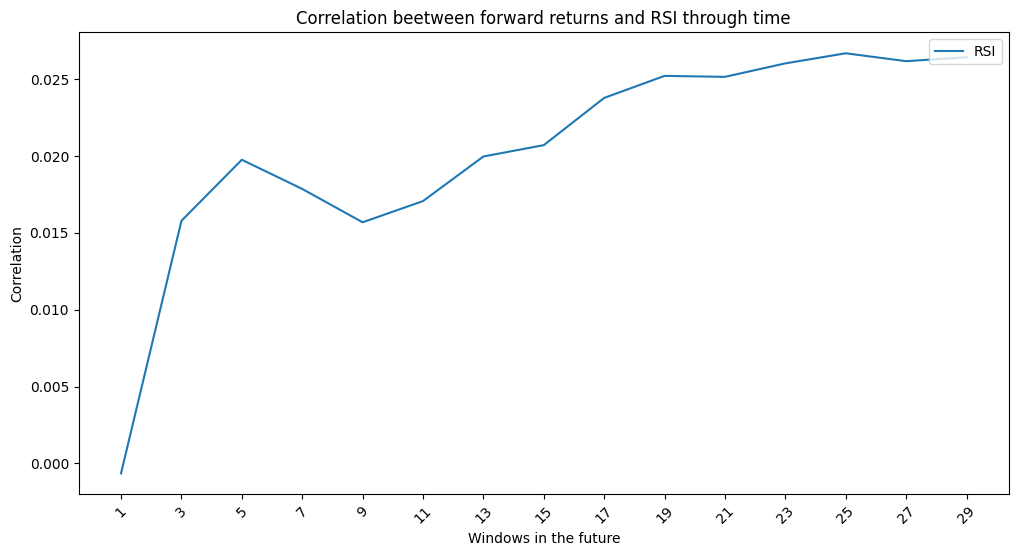

In [66]:
def plot_auto_corr_forward(name,auto_corr_forward):
    plt.plot(auto_corr_forward.columns,auto_corr_forward[auto_corr_forward.index==name].values[0], label=name)
    plt.xlabel("Windows in the future")
    plt.xticks(rotation = 45)
    plt.ylabel("Correlation")
    plt.title("Correlation beetween forward returns and "+name+" through time")
    plt.legend(loc="upper right")
    fig=plt.gcf()
    ax = plt.gca()
    #ax.set_xticks(ax.get_xticks()[::5])
    fig.set_size_inches(12,6)
plot_auto_corr_forward("RSI",auto_corr_forward)

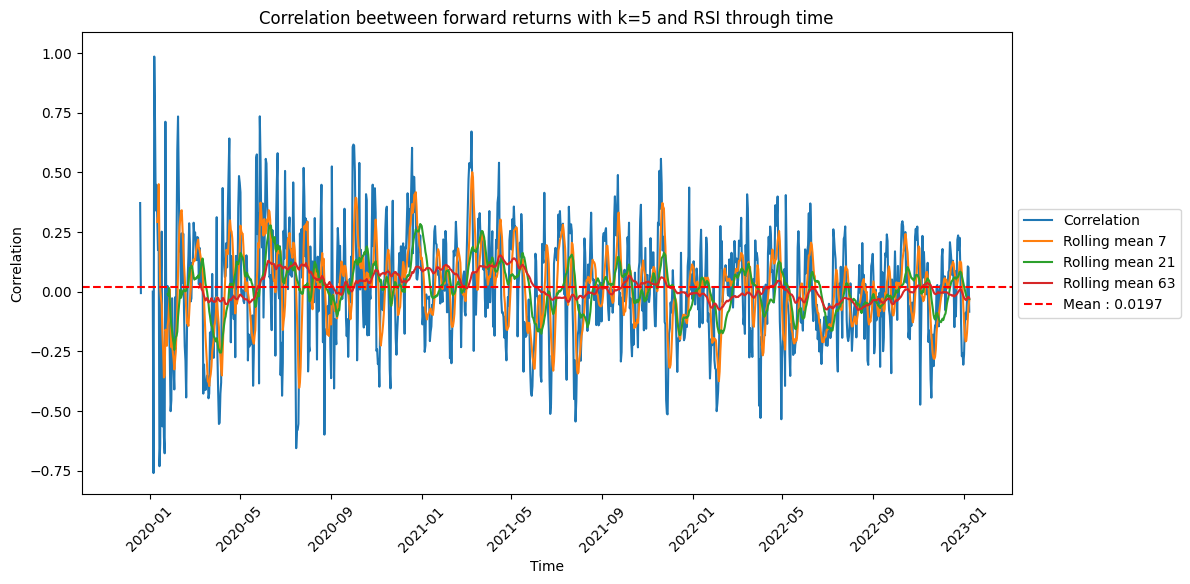

In [74]:
def plot_fwd_return(auto_corr_forward,name,window):
    """_summary_

    Args:
        auto_corr_forward (dataframe): dataframe of correlations line by line
        name (string): ex -> "RSI"
        window (int): value of window to compute in the future
    """
    
    roll21=auto_corr_forward.rolling(21).mean()
    roll7=auto_corr_forward.rolling(7).mean()
    roll63=auto_corr_forward.rolling(63).mean()
    m=auto_corr_forward.mean()
    plt.plot(auto_corr_forward.index,auto_corr_forward.values, label="Correlation")
    plt.plot(roll7.index,roll7.values,label="Rolling mean 7")
    plt.plot(roll21.index,roll21.values,label="Rolling mean 21")
    plt.plot(roll63.index,roll63.values,label="Rolling mean 63")
    plt.axhline(y = m, color = 'r', linestyle = 'dashed',label="Mean : "+str(round(m,4)))
    plt.xlabel("Time")
    plt.xticks(rotation = 45)
    plt.ylabel("Correlation")
    plt.title("Correlation beetween forward returns with k="+str(window)+" and "+name+" through time")
    #plt.legend(loc="upper right")
    fig=plt.gcf()
    ax=plt.gca()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    fig.set_size_inches(12,6)
    
def correlation_signal_vs_forward(returns,signal_name,all_signals,window,make_plot=False):
    """_summary_
    
    Function to plot correlation between signal and forward returns at horizon = window

    Args:
        returns (dataframe): dataframes of returns -> pct_change of close prices
        signal_name (string): ex -> "RSI"
        all_signals (dict): dict of signals dataframes
        window (int): value of window to compute in the future
        make_plot (bool): true if you want to show plot

    Returns:
        dataframe: dataframe of correlations line by line
    """
    
    signal=all_signals[signal_name].copy()
    s=normalize(signal)
    #-- we compute forward returns between t+1 and t+1+i
    forward=forward_returns(returns,window)
    cor=s.corrwith(forward, axis=1)
    m=cor.mean()
    if(make_plot):
        plot_fwd_return(cor,signal_name,window)
    return cor,m


returns=historic["Close"].pct_change()
cor_signal_forward,mean_cor=correlation_signal_vs_forward(returns=returns,
                                                          signal_name="RSI",
                                                          all_signals=all_frames,
                                                          window=5, 
                                                          make_plot=True,
                                                          )

In [84]:
def convert_to_weights(df):
    """_summary_
    
    Function to convert a signal into weights
    
    Args:
        df (dataframe): a normalized signal

    Returns:
        dataframe: a df where sum of absolute values of each row equals 1
    """
    temp=df.copy()
    temp=temp.div(temp.abs().sum(axis=1),axis=0)
    return temp

def get_turnover(df):
    """_summary_

    Function to get turnover day by day of our signal already normalized
    
    Args:
        df (dataframe): signal datframe normalized

    Returns:
        series: time series of turnover
    """
    temp=df.copy()
    #-- we convert our signal into weights
    temp=convert_to_weights(temp)
    temp2=temp.diff().abs()
    temp2=temp2.sum(axis=1)
    return temp2

def get_half_life(signal):
    """_summary_

    Compute half life of a signal

    Args:
        signal (dataframe): signal dataframe

    Returns:
        int: period of our signal half life
    """
    n=0
    cor=1
    #-- we stop at 25 to avoid infinite loops
    while((cor>0.5) and (n<25)):
        n=n+1
        cor=signal.corrwith(signal.shift(n), axis=1).mean()
    return n


In [230]:
def signals_weighted_evaluation(historic,all_signals,norm_signal):
    #-- we create "returns" data frame
    returns=historic["Close"].pct_change()

    #returns=returns.replace([-np.inf,np.inf],[np.nan,np.nan])
    data=[]
    pnls={}
    #-- we evaluate all signals in the dictionary "all_signals"
    for i in all_signals.keys():
        #--we collect our signal and we normalize it
        temp=all_frames[i].copy()
        if(norm_signal==1):
            temp=normalize(all_frames[i]).copy()
        elif(norm_signal==2):
            temp=normalize2(all_frames[i]).copy()
        elif(norm_signal==4):
            temp=normalize4(all_frames[i]).copy()
        elif(norm_signal==5):
            temp=normalize5(all_frames[i]).copy()
        
        d={}
        d["Signal_Name"]=i
        
        weights_df=convert_to_weights(temp)
        #-- we create pnl with different lags
        #-- we multiply signal with returns, and we check that "returns" have the exact same shape as "weights"
        pnl = (weights_df.shift(1) * returns[returns.index.isin(weights_df.index)][weights_df.columns]).sum(axis=1)
        d["daily_pnl"]=pnl.mean()
        pnls[i]=pnl
        
        turnover_series=get_turnover(weights_df)
        d["mean_daily_turnover"]=turnover_series.mean()
        
        #d["half_life"]=get_half_life(temp)
        
        horizons=[1, 2, 3, 5, 10, 20, 30, 60, 120]
        for j in horizons:
            #-- for each horizon, we compute the correlation between forward_returns and our signal      
            cor_signal_forward,mean_cor=correlation_signal_vs_forward(returns=returns,
                                                          signal_name=i,
                                                          all_signals=all_frames,
                                                          window=j, 
                                                          make_plot=False,
                                                          )
            d["Mean_cor_forward_"+str(j)]=mean_cor
        
        data.append(d)
    
    #-- Dataframe containing all pnls, one for each signal
    pnls_df=pd.DataFrame(pnls)
       
    #-- we return a data frame with all results    
    df=pd.DataFrame.from_dict(data).sort_values("Mean_cor_forward_1",ascending=False)
    
    fee_binance=0.0007
    df["daily_benefit"]=df["daily_pnl"]-fee_binance*df["mean_daily_turnover"]
    df["annual_benefit"]=df["daily_benefit"]*365
    
    df=df.reset_index(drop=True)
    df=df.sort_values(by="annual_benefit",ascending=False)
    return df,pnls_df


#-- norm_signal = 1 for normalization by mean an standard deviation, 
#                 2 for normalization by mean and median of absolute values
#                 4 for normalization by PowerTransformer(method="yeo-johnson")
#                 5 for normalization by QuantileTransformer(output_distribution="normal")
eval_signals_df,pnls_df=signals_weighted_evaluation(
    historic=historic,
    all_signals=all_frames,
    norm_signal=1
    )
eval_signals_df.head(10)

,Signal_Name,daily_pnl,mean_daily_turnover,Mean_cor_forward_1,Mean_cor_forward_2,Mean_cor_forward_3,Mean_cor_forward_5,Mean_cor_forward_10,Mean_cor_forward_20,Mean_cor_forward_30,Mean_cor_forward_60,Mean_cor_forward_120,daily_benefit,annual_benefit
4,cci_19,0.001417,0.403174,0.017202,0.031222,0.040236,0.035622,0.030423,0.031433,0.011331,-0.003362,-0.000609,0.001135,0.414291
2,cci_21,0.001398,0.380972,0.018091,0.030742,0.039400,0.034445,0.032619,0.034867,0.013291,-0.001899,-0.000657,0.001131,0.412995
3,cci_20,0.001402,0.390821,0.017288,0.031330,0.040779,0.035931,0.033090,0.035035,0.013964,-0.003176,-0.000551,0.001128,0.411789
1,on_balance_volume,0.001078,0.055088,0.018180,0.024406,0.033205,0.038484,0.053325,0.063429,0.066478,0.034055,0.029897,0.001039,0.379401
23,force_index,0.001232,0.320107,0.005464,0.003985,0.006861,0.000468,-0.007101,-0.009888,-0.027988,-0.024654,-0.009252,0.001008,0.367878
0,vortex_indicator_pos,0.001247,0.356337,0.021877,0.029088,0.033395,0.031925,0.028304,0.026006,0.007314,-0.017599,-0.010646,0.000998,0.364168
5,stoch_oscillator_signal,0.001171,0.294379,0.016003,0.024790,0.031215,0.028796,0.022443,0.022121,0.014445,0.010971,0.000608,0.000965,0.352078
9,stoch_rsi_k,0.001119,0.339154,0.008787,0.017548,0.017505,0.017108,0.002545,0.006687,0.008301,0.011036,0.028911,0.000882,0.321854
41,bol_wband,0.000935,0.146431,-0.005991,0.003563,0.010475,0.015290,0.024108,0.034801,0.018341,-0.003211,-0.019419,0.000832,0.303765
24,TSI,0.000881,0.101107,0.005361,0.009791,0.013064,0.018587,0.007941,-0.009521,-0.022743,-0.040927,-0.046092,0.000810,0.295813


### Plot of annual benefits

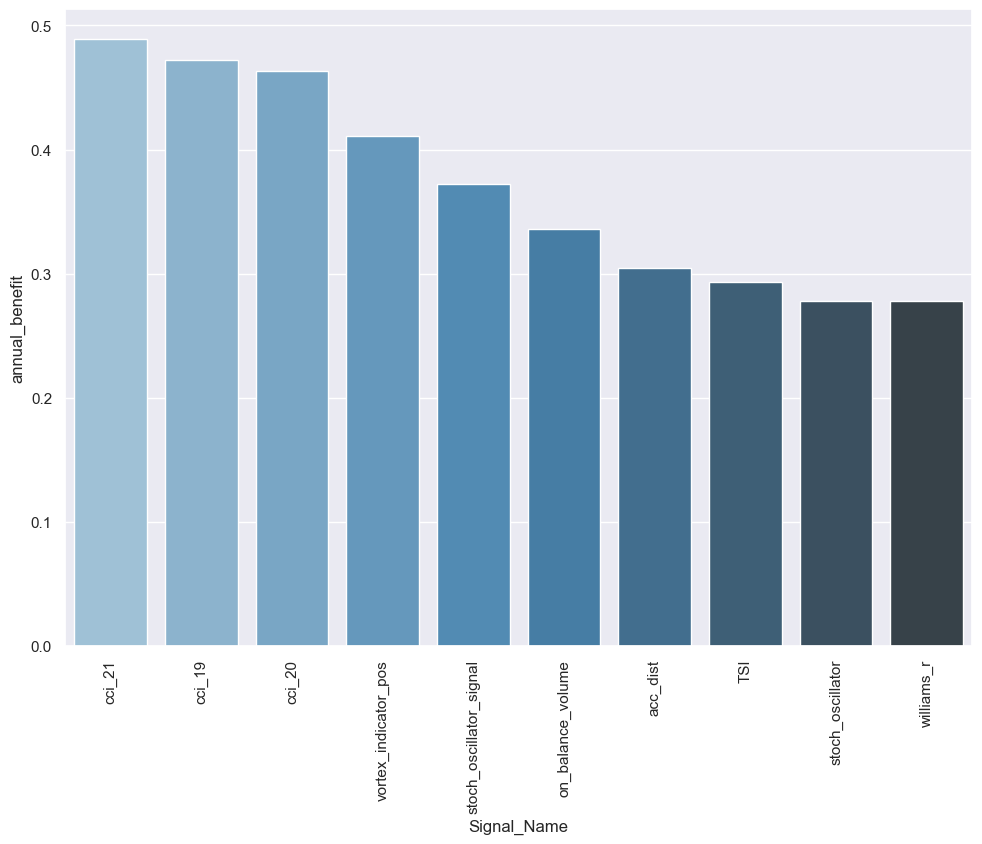

In [70]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
pl=sns.barplot(data=eval_signals_df,x=eval_signals_df["Signal_Name"].iloc[:10], 
               y="annual_benefit",
               palette="Blues_d" 
               #order=eval_signals_df["annual_benefit"].index
               )
ax = pl.axes
ax.tick_params(axis='x', rotation=90)

### Plot correlation with forward returns through different horizons

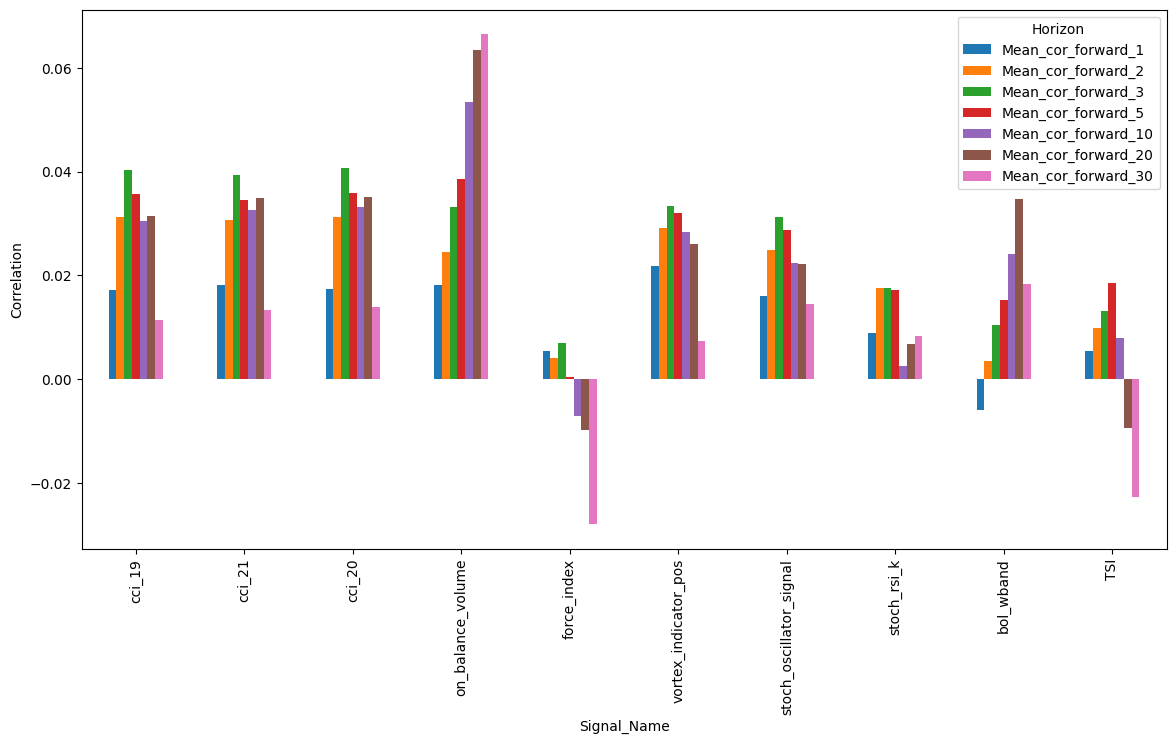

In [79]:
fig, ax = plt.subplots()
eval_signals_df.iloc[:10].plot.bar(x = 'Signal_Name', y = ["Mean_cor_forward_1",
                                "Mean_cor_forward_2","Mean_cor_forward_3","Mean_cor_forward_5",
                                "Mean_cor_forward_10","Mean_cor_forward_20","Mean_cor_forward_30"], rot = 90, ax = ax)
fig.set_size_inches(14, 7)
ax.set_ylabel("Correlation")
plt.legend(title="Horizon")

### Combination of all signals together

Find clusters of most similar signals, based on their pnls

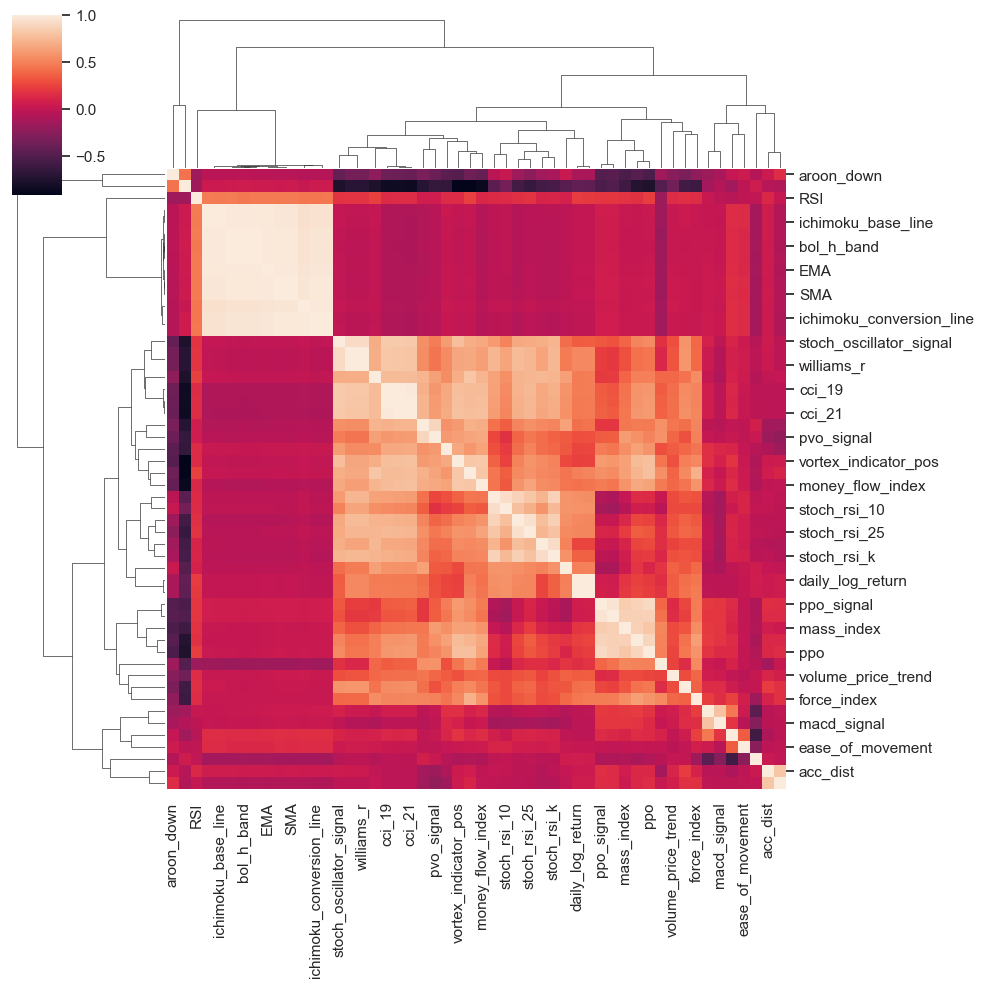

In [113]:
from scipy.cluster.hierarchy import fcluster

corr_pnls=pnls_df.corr().dropna(axis=1,how="all").dropna(axis=0,how="all")

cm=sns.clustermap(
    corr_pnls,
)
# Extract the linkage matrix
linkage = cm.dendrogram_row.linkage

# Extract the clusters using the fcluster function
clusters = fcluster(linkage, t=1.5, criterion='distance')

Extract clusters and assign weights to each signal

In [234]:
clusters_signals = pd.DataFrame({'Signals': corr_pnls.columns, 'clusters': clusters})

#-- get the number of signals in a cluster
temp=clusters_signals.groupby("clusters",as_index=False).count()
temp=temp.rename(columns={"Signals":"occurences_in_clusters"})
clusters_signals=clusters_signals.merge(temp,on="clusters")

#-- assign weights, based on the size of clusters
nb_clusters=len(clusters_signals["clusters"].unique())
clusters_signals["weights"]=(1/nb_clusters)*(1/clusters_signals["occurences_in_clusters"])
clusters_signals.sort_values("clusters").head(10)

,Signals,clusters,occurences_in_clusters,weights
43,aroon_down,1,1,0.076923
45,vortex_indicator_neg,2,1,0.076923
25,bol_h_band,3,11,0.006993
27,bol_mavg,3,11,0.006993
26,bol_l_band,3,11,0.006993
24,WMA,3,11,0.006993
23,ichimoku_conversion_line,3,11,0.006993
22,ichimoku_base_line,3,11,0.006993
21,ichimoku_b,3,11,0.006993
20,ichimoku_a,3,11,0.006993


Results with the initial weights, by clusters, with a lag of one day : 
Daily turnover :  0.4289
Annual benefit :  0.2032
Sharpe ratio :  1.1622
PnL : 


<AxesSubplot: xlabel='timestamp'>

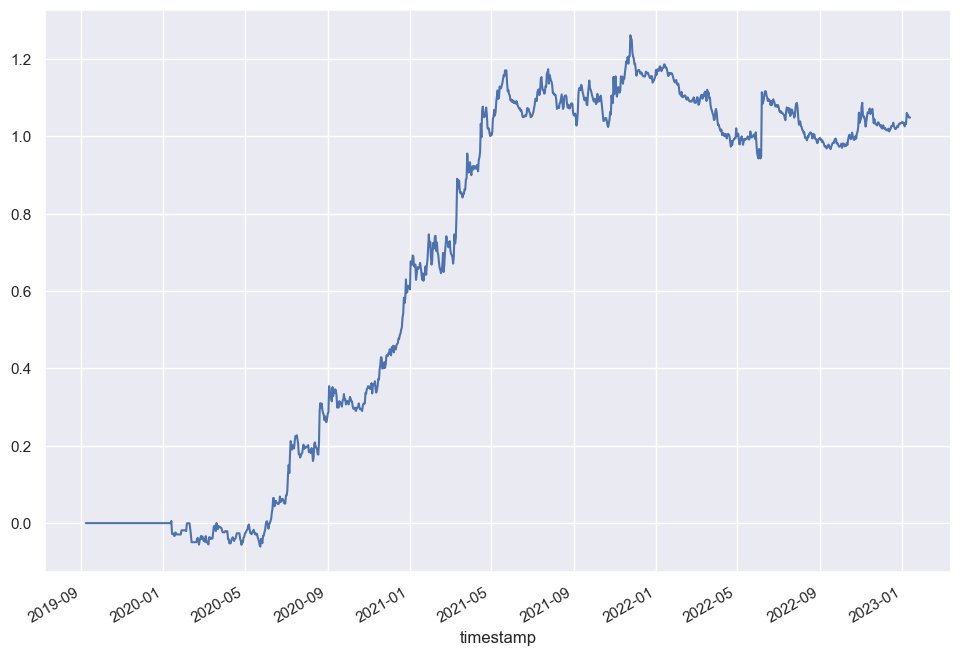

In [238]:
clusters_signals=clusters_signals.sort_values("Signals")
def fitness(weights,lag,start_date):
    """_summary_
        Function to evaluate a combined signals matrix
    Args:
        weights (array[float]): weights to assign to each signal
        lag (int): lag to choose for the computation of PnL
        start_date (string): beginning of the period we want to study

    Returns:
        dictionnary: all metrics of our combined signals matrix
    """
    #-- assign new weights to each signal
    clusters_signals["weights"]=weights
    
    #-- we collect as first signal the signal with the less empty values
    first_signal=eval_controlled_df["Signal_Name"][eval_controlled_df["pct_empty_values"]==eval_controlled_df["pct_empty_values"].min()].iloc[0]
    temp_df=normalize(all_frames[first_signal][all_frames[first_signal].index>=start_date]).copy()
    #temp_df=convert_to_weights(temp_df)
    
    #-- we get the weight assigned to this signal
    coeff=clusters_signals["weights"][clusters_signals["Signals"]==first_signal].iloc[0]
    #-- we multiply the normalized signal by its weight
    signals_together=coeff*temp_df

    #-- we had all signals together with their corresponding weights
    list_of_signal=[i for i in clusters_signals["Signals"].unique() if i!=first_signal]
    for signal in clusters_signals["Signals"].unique():
        temp_df=normalize(all_frames[signal][all_frames[signal].index>=start_date]).copy()
        #temp_df=convert_to_weights(temp_df)
        
        #-- we get the weight assigned to this signal
        coeff=clusters_signals["weights"][clusters_signals["Signals"]==signal].iloc[0]
        #-- we multiply the normalized signal by its weight and we add it to our matrix of combined signals
        signals_together=signals_together+coeff*temp_df
        
    #-- collect all metrics of our combined signal matrix
    d={}   
    signals_together=normalize(signals_together)
    signals_together=convert_to_weights(signals_together)
    turnover_series=get_turnover(signals_together)
    d["mean_daily_turnover"]=turnover_series.mean()
    d["pct_empty"]=signals_together.isnull().sum().sum()/(signals_together.shape[0]*signals_together.shape[1])*100
    d["pnl"] = (signals_together.shift(lag) * returns[returns.index.isin(signals_together.index)][signals_together.columns]).sum(axis=1)
    d["sharpe"]=d["pnl"].mean() * (365)**0.5 / d["pnl"].std()
    d["daily_pnl"]=d["pnl"].mean()
    fee_binance=0.0007
    d["daily_benefit"]=d["daily_pnl"]-fee_binance*d["mean_daily_turnover"]
    d["annual_benefit"]=d["daily_benefit"]*365
    return d

def fitness_func(solution,solution_idx):
    """_summary_
        Function to run in order to evaluate an individual in the genetic algorithm
    Args:
        solution (array[float]): weights to assign to each signal
        solution_idx (int): index of the solution

    Returns:
        float: annual benefit of our combined signal matrix (value to improve)
    """
    d=fitness(solution,1,"01-01-2022")
    return d["annual_benefit"]

weights=clusters_signals["weights"].values
result=fitness(weights,1,"01-01-2015")

print("Results with the initial weights, by clusters, with a lag of one day : ")
print("Daily turnover : ",round(result["mean_daily_turnover"],4))
print("Annual benefit : ",round(result["annual_benefit"],4))
print("Sharpe ratio : ",round(result["sharpe"],4))
print("PnL : ")
result["pnl"].cumsum().plot()

In [225]:
#-- one hour runtime
lags=[1,2,3,5]
res=[]

#-- we run a genitical algorithm on different lags
for i in lags :
    print("Lag : ",i)
    
    #-- we update our fitness function, based on the current lag
    def fitness_func(solution,solution_idx):
        d=fitness(solution,i,"01-01-2015")
        return d["annual_benefit"]
    
    fitness_function = fitness_func

    #-- for each lag, we run 100 generations
    num_generations = 100
    num_parents_mating = 4

    sol_per_pop = 8
    num_genes = len(weights)

    #-- at the beginning, all weights are generated randomly between 0 and 1
    init_range_low = 0
    init_range_high = 1

    parent_selection_type = "sss"
    keep_parents = 1

    crossover_type = "single_point"

    mutation_type = "random"
    mutation_percent_genes = 10

    ga_instance = pygad.GA(num_generations=num_generations,
                        num_parents_mating=num_parents_mating,
                        fitness_func=fitness_func,
                        sol_per_pop=sol_per_pop,
                        num_genes=num_genes,
                        init_range_low=init_range_low,
                        init_range_high=init_range_high,
                        parent_selection_type=parent_selection_type,
                        keep_parents=keep_parents,
                        crossover_type=crossover_type,
                        mutation_type=mutation_type,
                        mutation_percent_genes=mutation_percent_genes)
    ga_instance.run()
    
    #-- get best combination of weights for a lag
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    d={}
    d["weights"]=solution
    d["lags"]=i
    d["annual_benefit"]=solution_fitness
    d["ga_instance"]=ga_instance
    res.append(d)
    
#-- Convert our results to a dataframe
res_df=pd.DataFrame(res)
res_df


Lag :  1
Lag :  2
Lag :  3
Lag :  5


,weights,lags,annual_benefit,ga_instance
0,"[-2.7025272259844924, -1.5214151592437486, -1....",1,0.788700,<pygad.pygad.GA object at 0x000001CDDBD60610>
1,"[0.13822606980615015, -1.139325419515279, 0.20...",2,0.788453,<pygad.pygad.GA object at 0x000001CDDBD6F910>
2,"[-0.7684525995893503, -0.47023177280655126, -1...",3,0.842433,<pygad.pygad.GA object at 0x000001CDDBD6D8A0>
3,"[1.0742593995173804, -0.12603759655984104, 2.5...",5,0.501376,<pygad.pygad.GA object at 0x000001CDDBD60520>


Parameters of the best solution : [-3.4589158  -1.52141516 -1.25297464  3.90961082  1.65604198 -1.33783565
  2.4650507  -2.21633592 -1.15854488  1.05513148 -0.99293178 -1.0521245
  0.03642724  4.4105687   2.87311258  1.51609755  0.01268618  1.53395859
 -3.46510427  0.62691506  2.0063825  -0.39330927  3.04658418 -1.84365265
 -0.97951091 -0.12406876  2.1709399  -0.20341786 -3.68991488  1.20978205
 -0.52280835 -0.84073245 -1.38068249 -1.44693965 -0.66024877 -0.71479752
 -0.68848829 -1.15339494 -2.18935711  0.36344726 -0.47840021  1.99253803
  0.59684809  0.20276793  1.62684913  1.88958873 -1.09088017 -2.28419123
  1.6805453   0.75329078  0.9554726   0.45628052]
Fitness value of the best solution = 0.7822720456406205


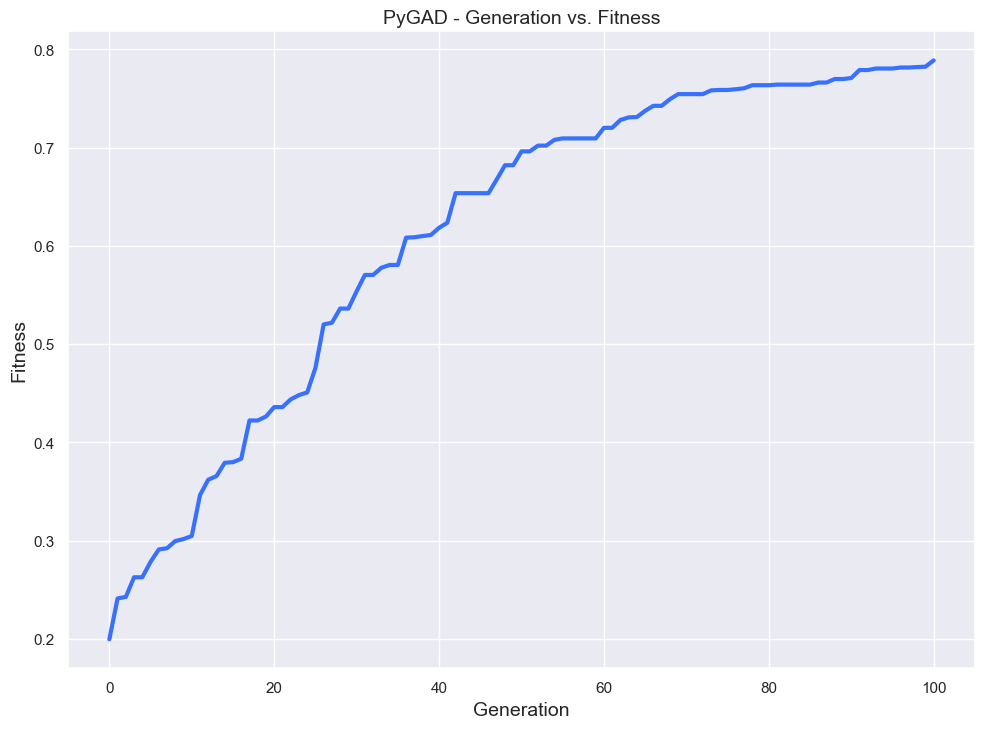

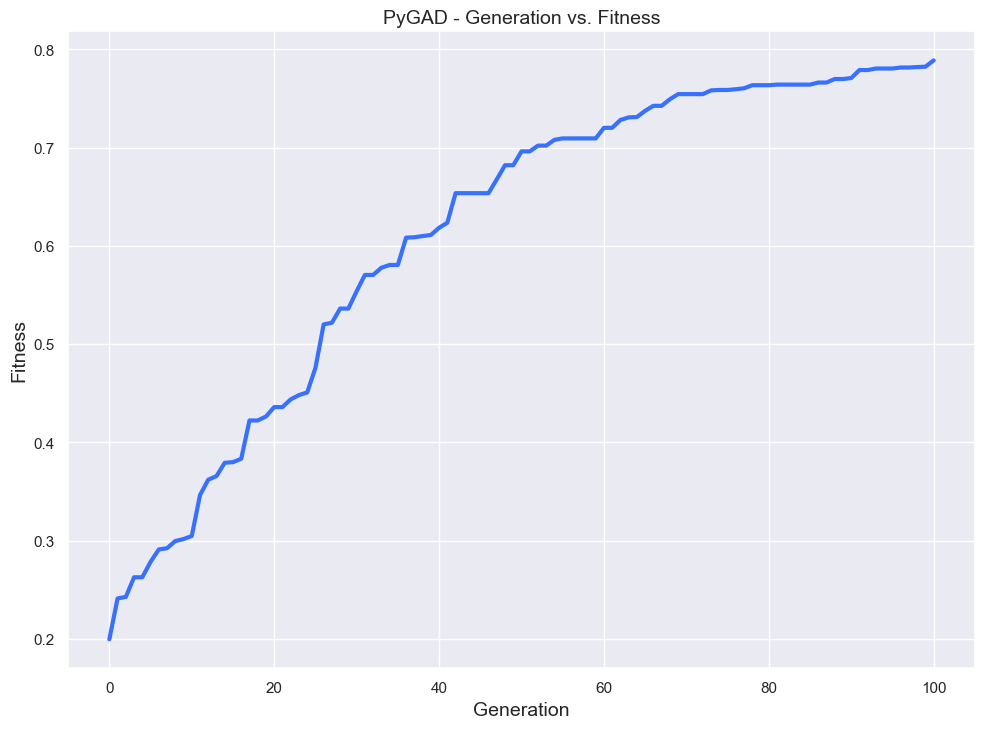

In [242]:
#-- understand results for a certain lag
lag=1
ga_instance=res_df["ga_instance"][res_df["lags"]==lag].iloc[0]
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

#-- plot annual benefit by iterations
ga_instance.plot_result()

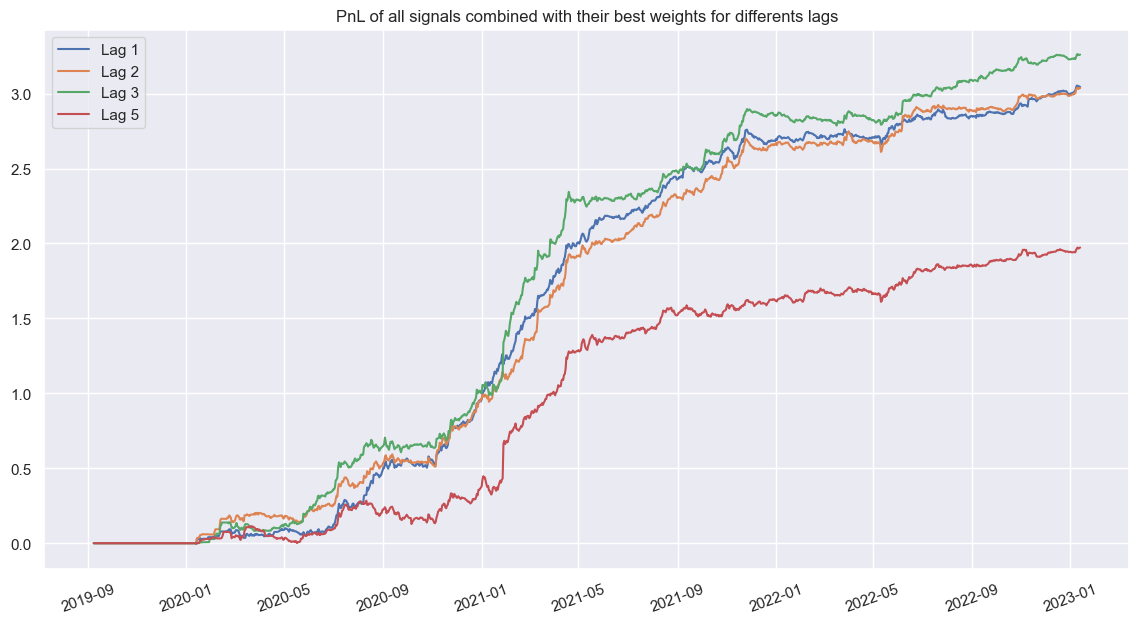

In [251]:
#-- we plot the pnl of the best configuration of weights for each lag
weights=solution
lags=[1,2,3,5]
for i in range(len(res_df)):
    weights=res_df["weights"].iloc[i]
    temp_res=fitness(weights,lags[i],"01-01-2015")
    pnl = temp_res["pnl"]
    plt.plot(pnl.index,pnl.cumsum(), label="Lag "+str(lags[i]))
plt.legend(loc="upper left")
plt.title("PnL of all signals combined with their best weights for differents lags")
plt.xticks(rotation = 20)
fig=plt.gcf()
fig.set_size_inches(14, 7)

For a certain lag, visualize the weight of each signal

In [256]:
lag=3
weights=res_df["weights"][res_df["lags"]==lag].iloc[0]
temp=[]
for i in range(len(weights)):
    d={}
    #-- weights and signals are in the same position because we keep the same order all the time
    d["signal"]=clusters_signals["Signals"].iloc[i]
    d["weight"]=weights[i]
    temp.append(d)
signal_with_weight=pd.DataFrame(temp)
signal_with_weight.sort_values("weight",ascending=False)

,signal,weight
48,volume_price_trend,6.260830
31,on_balance_volume,3.109595
14,cci_19,2.799841
44,stoch_rsi_25,2.741416
13,bol_wband,2.232915
4,TSI,2.192153
29,mass_index,1.831295
39,stoch_oscillator,1.034927
49,vortex_indicator_neg,1.004958
51,williams_r,0.862338


In [258]:
result=fitness(weights,3,"01-01-2015")

print("Results with weights for a lag of 3 days : ")
print("Daily turnover : ",round(result["mean_daily_turnover"],4))
print("Annual benefit : ",round(result["annual_benefit"],4))
print("Sharpe ratio : ",round(result["sharpe"],4))

Results with weights for a lag of 3 days : 
Daily turnover :  0.5108
Annual benefit :  0.8418
Sharpe ratio :  3.6462
